## **Contenido**

[**1. Perceptron multi-capa**](#tema1)

[**2. Perceptron multi-capa en pytorch**](#tema2)

[**3. Redes Neuronales Convolucionales**](#tema3)


[**4. Preguntas**](#tema7)

## <font color='#4C5FDA'>**Segmentación de imagenes vasculares de la retina** </font> <a name="tema1">

In [ ]:
! pip install kaggle segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"henrymantilla","key":"5a89db167b72fc91af23dc18b3bb61cb"}'}

In [ ]:
!mkdir ~/kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torchvision.datasets import ImageFolder

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms, utils
import torchvision.transforms.v2 as transforms

import segmentation_models_pytorch as smp
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import albumentations as A
from PIL import Image
from glob import glob
from tqdm import tqdm

In [ ]:
! kaggle datasets download -d abdallahwagih/retina-blood-vessel
! unzip retina-blood-vessel.zip

In [ ]:
train_img_paths = sorted(glob('/content/Data/train/image/*.png'))
train_mask_paths = sorted(glob('/content/Data/train/mask/*.png'))
train_df = pd.DataFrame({"images":train_img_paths,"masks":train_mask_paths})
train_df.head()

,images,masks
0,/content/Data/train/image/0.png,/content/Data/train/mask/0.png
1,/content/Data/train/image/1.png,/content/Data/train/mask/1.png
2,/content/Data/train/image/10.png,/content/Data/train/mask/10.png
3,/content/Data/train/image/11.png,/content/Data/train/mask/11.png
4,/content/Data/train/image/12.png,/content/Data/train/mask/12.png


In [ ]:
test_img_paths = sorted(glob('/content/Data/test/image/*.png'))
test_mask_paths = sorted(glob('/content/Data/test/mask/*.png'))
test_df = pd.DataFrame({"images":test_img_paths,"masks":test_mask_paths})
test_df.head()

,images,masks
0,/content/Data/test/image/0.png,/content/Data/test/mask/0.png
1,/content/Data/test/image/1.png,/content/Data/test/mask/1.png
2,/content/Data/test/image/10.png,/content/Data/test/mask/10.png
3,/content/Data/test/image/11.png,/content/Data/test/mask/11.png
4,/content/Data/test/image/12.png,/content/Data/test/mask/12.png


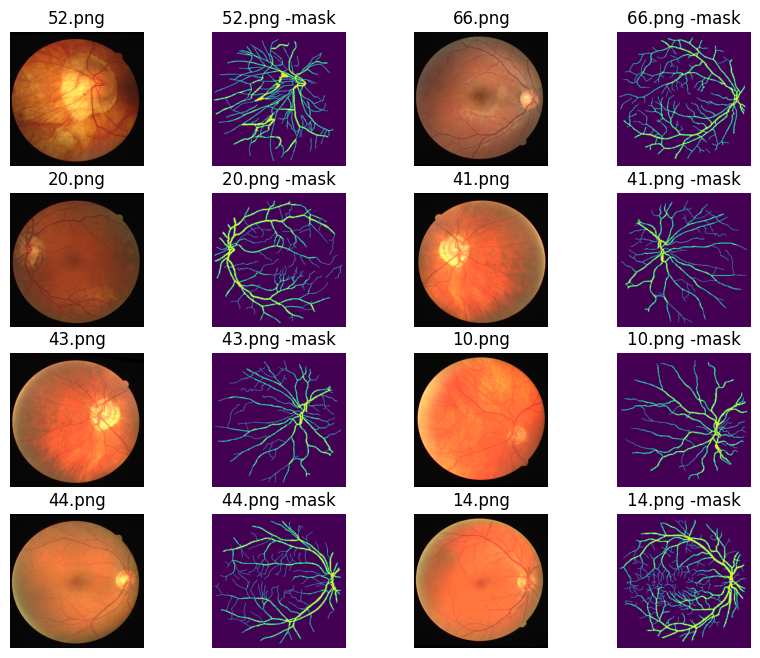

In [ ]:
show_imgs = 8
idx = np.random.choice(len(train_df), show_imgs, replace=False)
fig, axes = plt.subplots(show_imgs*2//4, 4, figsize=(10, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    new_i = i//2
    if i % 2 ==0 :
        full_path = train_df.loc[idx[new_i]]['images']
        basename = os.path.basename(full_path)
    else:
        full_path = train_df.loc[idx[new_i]]['masks']
        basename = os.path.basename(full_path) + ' -mask'
    ax.imshow(plt.imread(full_path))
    ax.set_title(basename)
    ax.set_axis_off()

In [ ]:
### Elige trasnformaciones para hacer data augmentation
### Puedes encontrar informacion acerca de las transformaciones disponibles en https://albumentations.ai/docs/api_reference/augmentations/
train_transforms = A.Compose([

])

test_transforms = A.Compose([

])

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_=None):
        self.df = dataframe
        self.transforms_ = transforms_
        self.resize = [256, 256]
        self.class_size = 2

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['images']), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.df.iloc[index]['masks'],cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        aug = self.transforms_(image=img, mask=mask)
        img, mask = aug['image'], aug['mask']
        img = img/255

        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'image': img, 'mask': target}
        return sample

In [ ]:
train_dataset = #Invoca la clase MyDataset declarada para el dataset de entrenamiento
val_dataset = #Invoca la clase MyDataset declarada para el dataset de validacion

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
print(f'len train: {len(train_df)}')
print(f'len val: {len(test_df)}')

len train: 80
len val: 20


In [ ]:
class DoubleConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
     super().__init__()
     self.double_conv = nn.Sequential(
         #Declara las capas necesarias para realizar la doble convolución descrita en el diagrama de la UNet
     )

  def forward(self, x):
    return self.double_conv(x)


class Downscaling(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.maxpool_conv = ##Añade el max pooling al bloque de doble convolución

  def forward(self, x):
    return self.maxpool_conv(x)


class Upscaling(nn.Module):
  def __init__(self, in_channels, out_channels, bilinear=True):
    super().__init__()

    ## Declara las capas necesarias para aumentar la escala de los mapas de caracteristicas
    ## Puedes emplear interpolación o convolución transpuesta para lograrlo

  def forward(self, x1, x2):
      x1 = self.up(x1)
      # input is CHW
      diffY = x2.size()[2] - x1.size()[2]
      diffX = x2.size()[3] - x1.size()[3]

      x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])

      x = torch.cat([x2, x1], dim=1)
      return self.conv(x)


class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = #declara la capa de salida segun las clases de tu dataset

  def forward(self, x):
    return self.conv(x)

In [ ]:
class UNet(nn.Module):
  def __init__(self, n_channels, n_classes, bilinear=False):
    super().__init__()

    self.n_channels = n_channels
    self.n_classes = n_classes
    self.bilinear = bilinear

    ## Siguiendo la estructura de la Unet, crea el modelo con los bloques declarados arriba

  def forward(self, x):

    ## Crea el forward de la UNet, no olvides las conexiones residuales

    return logits

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(n_channels=3, n_classes=1)

model.to(device)
criterion = smp.losses.DiceLoss(mode="binary")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)
epochs = 100

for epoch in range(epochs+1):
  model.train()
  epoch_loss = 0
  epoch_iou_score = 0
  train_iters = 0

  for _, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}')):

    images, true_mask = batch['image'].to(device), batch['mask'].to(device)
    optimizer.zero_grad()

    pred_masks = model(images)
    pred = pred_masks.squeeze(dim=1)

    loss = criterion(pred, true_mask)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    true_mask = true_mask.round().long()
    tp, fp, fn, tn = smp.metrics.get_stats(pred, true_mask, mode='binary', threshold=0.5)
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
    epoch_iou_score += iou_score
    train_iters += 1

  print(f"Epoch Loss: {epoch_loss/train_iters:.4f}, Dice: {loss:.4f}, IoU: {epoch_iou_score:.4f}")

Epoch 0/100: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch Loss: 0.7860, Dice: 0.7600, IoU: 1.4577


Epoch 1/100: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Epoch Loss: 0.7277, Dice: 0.7152, IoU: 2.6339


Epoch 2/100: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch Loss: 0.6909, Dice: 0.6918, IoU: 3.1450


Epoch 3/100: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Epoch Loss: 0.6683, Dice: 0.6722, IoU: 3.4306


Epoch 4/100: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Epoch Loss: 0.6545, Dice: 0.6660, IoU: 3.5927


Epoch 5/100: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Epoch Loss: 0.6394, Dice: 0.6416, IoU: 3.9462


Epoch 6/100: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch Loss: 0.6325, Dice: 0.6248, IoU: 3.9906


Epoch 7/100: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Epoch Loss: 0.6224, Dice: 0.6250, IoU: 4.1884


Epoch 8/100: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch Loss: 0.6168, Dice: 0.6059, IoU: 4.2582


Epoch 9/100: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch Loss: 0.6144, Dice: 0.6326, IoU: 4.2913


Epoch 10/100: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch Loss: 0.6029, Dice: 0.6185, IoU: 4.4409


Epoch 11/100: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Epoch Loss: 0.6055, Dice: 0.6086, IoU: 4.4210


Epoch 12/100: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Epoch Loss: 0.5897, Dice: 0.5831, IoU: 4.6531


Epoch 13/100: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch Loss: 0.5898, Dice: 0.5870, IoU: 4.6276


Epoch 14/100: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch Loss: 0.5840, Dice: 0.5736, IoU: 4.7290


Epoch 15/100: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch Loss: 0.5823, Dice: 0.6035, IoU: 4.7072


Epoch 16/100: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Epoch Loss: 0.5753, Dice: 0.5618, IoU: 4.7805


Epoch 17/100: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Epoch Loss: 0.5720, Dice: 0.5787, IoU: 4.8333


Epoch 18/100: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch Loss: 0.5667, Dice: 0.5502, IoU: 4.9075


Epoch 19/100: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Epoch Loss: 0.5617, Dice: 0.5662, IoU: 4.9035


Epoch 20/100: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Epoch Loss: 0.5590, Dice: 0.5555, IoU: 4.9647


Epoch 21/100: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epoch Loss: 0.5522, Dice: 0.5581, IoU: 4.9989


Epoch 22/100: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epoch Loss: 0.5497, Dice: 0.5389, IoU: 5.0051


Epoch 23/100: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch Loss: 0.5421, Dice: 0.5313, IoU: 5.1114


Epoch 24/100: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch Loss: 0.5397, Dice: 0.5390, IoU: 5.1100


Epoch 25/100: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch Loss: 0.5393, Dice: 0.5494, IoU: 5.0671


Epoch 26/100: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch Loss: 0.5366, Dice: 0.5255, IoU: 5.0715


Epoch 27/100: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch Loss: 0.5284, Dice: 0.5249, IoU: 5.1941


Epoch 28/100: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


Epoch Loss: 0.5253, Dice: 0.5222, IoU: 5.1876


Epoch 29/100: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch Loss: 0.5270, Dice: 0.5306, IoU: 5.1114


Epoch 30/100: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch Loss: 0.5215, Dice: 0.5206, IoU: 5.2199


Epoch 31/100: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch Loss: 0.5140, Dice: 0.5287, IoU: 5.2425


Epoch 32/100: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Epoch Loss: 0.5114, Dice: 0.5003, IoU: 5.2814


Epoch 33/100: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Epoch Loss: 0.5049, Dice: 0.5089, IoU: 5.2911


Epoch 34/100: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Epoch Loss: 0.5076, Dice: 0.4960, IoU: 5.3074


Epoch 35/100: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Epoch Loss: 0.5003, Dice: 0.4785, IoU: 5.3070


Epoch 36/100: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Epoch Loss: 0.4980, Dice: 0.4930, IoU: 5.3142


Epoch 37/100: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch Loss: 0.4972, Dice: 0.4917, IoU: 5.2715


Epoch 38/100: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch Loss: 0.4870, Dice: 0.4723, IoU: 5.3794


Epoch 39/100: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


Epoch Loss: 0.4884, Dice: 0.4976, IoU: 5.3656


Epoch 40/100: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epoch Loss: 0.4874, Dice: 0.4856, IoU: 5.3443


Epoch 41/100: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch Loss: 0.4788, Dice: 0.4523, IoU: 5.4082


Epoch 42/100: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch Loss: 0.4754, Dice: 0.4655, IoU: 5.4177


Epoch 43/100: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch Loss: 0.4709, Dice: 0.4533, IoU: 5.4356


Epoch 44/100: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch Loss: 0.4699, Dice: 0.4813, IoU: 5.4339


Epoch 45/100: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch Loss: 0.4641, Dice: 0.4542, IoU: 5.4640


Epoch 46/100: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch Loss: 0.4645, Dice: 0.4579, IoU: 5.4270


Epoch 47/100: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch Loss: 0.4603, Dice: 0.4506, IoU: 5.4810


Epoch 48/100: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch Loss: 0.4593, Dice: 0.4625, IoU: 5.4397


Epoch 49/100: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch Loss: 0.4539, Dice: 0.4609, IoU: 5.4943


Epoch 50/100: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch Loss: 0.4512, Dice: 0.4623, IoU: 5.4711


Epoch 51/100: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Epoch Loss: 0.4474, Dice: 0.4349, IoU: 5.5375


Epoch 52/100: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch Loss: 0.4423, Dice: 0.4545, IoU: 5.5663


Epoch 53/100: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Epoch Loss: 0.4419, Dice: 0.4372, IoU: 5.5419


Epoch 54/100: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch Loss: 0.4404, Dice: 0.4274, IoU: 5.5136


Epoch 55/100: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Epoch Loss: 0.4366, Dice: 0.4615, IoU: 5.5458


Epoch 56/100: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch Loss: 0.4312, Dice: 0.4172, IoU: 5.5791


Epoch 57/100: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch Loss: 0.4252, Dice: 0.4390, IoU: 5.6294


Epoch 58/100: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch Loss: 0.4296, Dice: 0.4344, IoU: 5.5536


Epoch 59/100: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch Loss: 0.4246, Dice: 0.4361, IoU: 5.5746


Epoch 60/100: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch Loss: 0.4213, Dice: 0.4139, IoU: 5.6081


Epoch 61/100: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Epoch Loss: 0.4232, Dice: 0.4276, IoU: 5.5384


Epoch 62/100: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Epoch Loss: 0.4152, Dice: 0.4073, IoU: 5.6357


Epoch 63/100: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch Loss: 0.4121, Dice: 0.4176, IoU: 5.6393


Epoch 64/100: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch Loss: 0.4138, Dice: 0.4151, IoU: 5.5931


Epoch 65/100: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch Loss: 0.4094, Dice: 0.3987, IoU: 5.5976


Epoch 66/100: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Epoch Loss: 0.4098, Dice: 0.3893, IoU: 5.5697


Epoch 67/100: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch Loss: 0.4083, Dice: 0.4091, IoU: 5.5903


Epoch 68/100: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch Loss: 0.3994, Dice: 0.4220, IoU: 5.6279


Epoch 69/100: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch Loss: 0.4021, Dice: 0.3910, IoU: 5.5910


Epoch 70/100: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch Loss: 0.3947, Dice: 0.3906, IoU: 5.6786


Epoch 71/100: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Epoch Loss: 0.3907, Dice: 0.4061, IoU: 5.6973


Epoch 72/100: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch Loss: 0.3946, Dice: 0.3736, IoU: 5.6490


Epoch 73/100: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epoch Loss: 0.3915, Dice: 0.4044, IoU: 5.6571


Epoch 74/100: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch Loss: 0.3867, Dice: 0.3734, IoU: 5.7046


Epoch 75/100: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch Loss: 0.3832, Dice: 0.3795, IoU: 5.6980


Epoch 76/100: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch Loss: 0.3776, Dice: 0.3804, IoU: 5.7468


Epoch 77/100: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch Loss: 0.3829, Dice: 0.3938, IoU: 5.6608


Epoch 78/100: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch Loss: 0.3797, Dice: 0.3755, IoU: 5.7004


Epoch 79/100: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Epoch Loss: 0.3787, Dice: 0.3834, IoU: 5.6768


Epoch 80/100: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch Loss: 0.3808, Dice: 0.3789, IoU: 5.6545


Epoch 81/100: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Epoch Loss: 0.3783, Dice: 0.3728, IoU: 5.6335


Epoch 82/100: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch Loss: 0.3728, Dice: 0.3587, IoU: 5.6938


Epoch 83/100: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch Loss: 0.3704, Dice: 0.3840, IoU: 5.6810


Epoch 84/100: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch Loss: 0.3706, Dice: 0.3728, IoU: 5.6771


Epoch 85/100: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epoch Loss: 0.3656, Dice: 0.3546, IoU: 5.7403


Epoch 86/100: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch Loss: 0.3642, Dice: 0.3552, IoU: 5.7083


Epoch 87/100: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Epoch Loss: 0.3620, Dice: 0.3466, IoU: 5.7436


Epoch 88/100: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Epoch Loss: 0.3627, Dice: 0.3594, IoU: 5.7081


Epoch 89/100: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Epoch Loss: 0.3570, Dice: 0.3664, IoU: 5.7718


Epoch 90/100: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch Loss: 0.3570, Dice: 0.3510, IoU: 5.7288


Epoch 91/100: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Epoch Loss: 0.3554, Dice: 0.3652, IoU: 5.7578


Epoch 92/100: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch Loss: 0.3563, Dice: 0.3319, IoU: 5.7370


Epoch 93/100: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch Loss: 0.3549, Dice: 0.3484, IoU: 5.7266


Epoch 94/100: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Epoch Loss: 0.3500, Dice: 0.3516, IoU: 5.7756


Epoch 95/100: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch Loss: 0.3505, Dice: 0.3570, IoU: 5.7305


Epoch 96/100: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Epoch Loss: 0.3459, Dice: 0.3545, IoU: 5.7791


Epoch 97/100: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch Loss: 0.3441, Dice: 0.3494, IoU: 5.7986


Epoch 98/100: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Epoch Loss: 0.3493, Dice: 0.3570, IoU: 5.7003


Epoch 99/100: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch Loss: 0.3434, Dice: 0.3537, IoU: 5.7721


Epoch 100/100: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]

Epoch Loss: 0.3401, Dice: 0.3431, IoU: 5.7888


In [ ]:
model.eval()
epoch_loss = 0
train_iters = 0
epoch_iou_score = 0

with torch.no_grad():
    for _, batch in enumerate(tqdm(val_loader, desc=f'Epoch {epoch}/{epochs}')):
        images, true_masks = batch['image'].to(device), batch['mask'].to(device)

        pred = model(images)
        loss = criterion(pred, true_masks)

        epoch_loss += loss.item()
        pred = pred.squeeze(dim=1)
        pred = torch.sigmoid(pred)
        true_mask = true_mask.round().long()
        tp, fp, fn, tn = smp.metrics.get_stats(pred, true_mask, mode='binary', threshold=0.5)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        epoch_iou_score += iou_score
        train_iters += 1

print(f"Epoch Loss: {epoch_loss/train_iters:.4f}, Dice: {loss:.4f}, IoU: {epoch_iou_score/train_iters:.4f}")

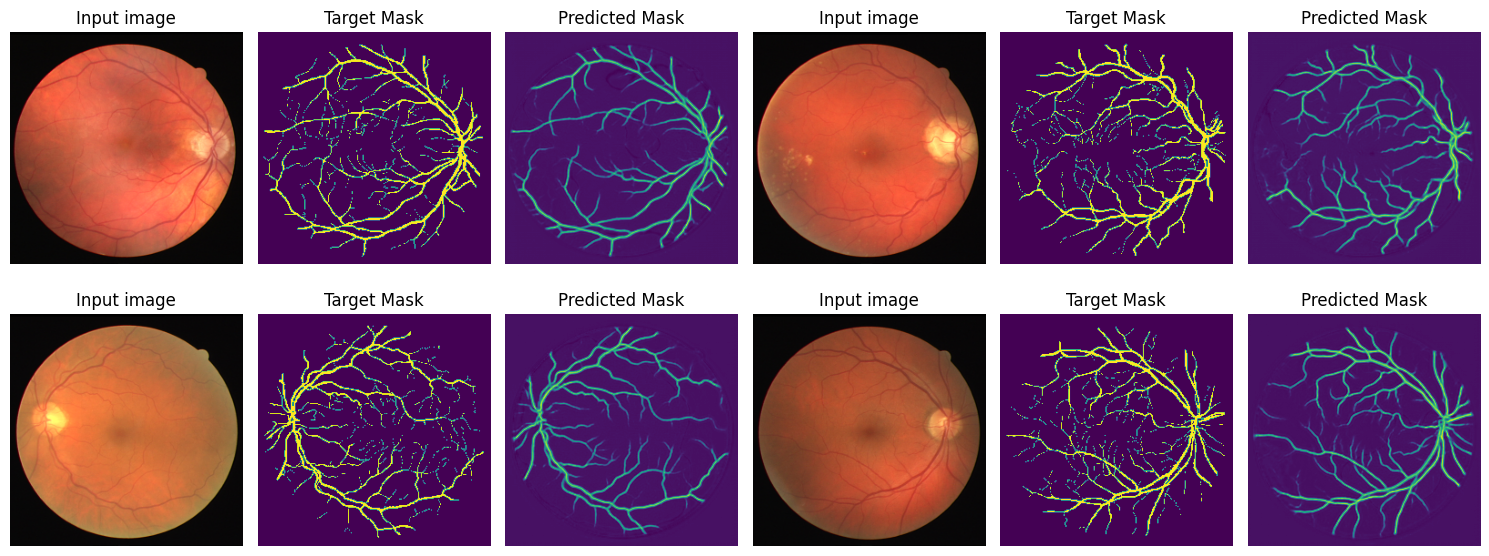

In [ ]:
#images, masks = next(iter(val_loader))
images, masks = batch['image'].to(device), batch['mask'].to(device)
with torch.no_grad():
  model_prediction = model(images)

model_prediction = torch.max(model_prediction,dim=1)[0]

rows, columns = 2, 6
num_images = 24
fig, axs = plt.subplots(rows, columns, figsize=(15, 6))
idx = 0
for row in range(rows):
    for col in range(0, 6, 3):
      if idx >= num_images:
          break

      img = images[idx].permute(1, 2, 0)
      mask = masks[idx].squeeze()
      predicted_masks = model_prediction[idx]


      axs[row, col].imshow(img.cpu())
      axs[row, col].set_title('Input image')
      axs[row, col].axis('off')

      axs[row, col+1].imshow(mask.cpu())
      axs[row, col+1].set_title('Target Mask')
      axs[row, col+1].axis('off')

      axs[row, col+2].imshow(predicted_masks.cpu())
      axs[row, col+2].set_title('Predicted Mask')
      axs[row, col+2].axis('off')

      idx += 1

plt.tight_layout()
plt.show()